
# Business Cases with Data Science 

## Case 2: Market Basket Analysis

#### Semester: Spring 2020
#### Group (Palm & Company) Member:
1. Pedro Santos (M20190420)
2. Ana Claudia Alferes (M20190932)
3. Lennart Dangers (M20190251)
4. Michael Machatschek (M20190054)

#### This project follows the CRISP-DM Process:

1. Business Understanding
2. Data Understanding
3. Data Preparation
4. Modelling
5. Evaluation
6. Deployment

This jupyter-notebook provides the code in python to do a market basket analysis of a given dataset. A more detailed description of this project and the solutions can be found in the report. 

# Business Understanding

Please consult our report for further details. 

# Data Understanding

## Dataset Description

A data dictionary is available in the appendix of our report.
 
 
 
 #### The following code will help to explore and understand the entire dataset. 

In [1]:
# Import packages
import csv
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import matplotlib.pyplot as plt
import networkx as nx
import plotly.offline as po 
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import itertools

In [2]:
# Load and show dataset sample (Chain of Asian Restaurant sales January 2018)
dtypes = {'DocNumber':'category','ProductDesignation':'category'}
df = pd.DataFrame(pd.read_csv("AsianRestaurant_Cyprus_2018.txt", sep=";"))

In [3]:
df.head()

DocNumber  ProductDesignation ProductFamily  Qty TotalAmount  \
0  TKD0320000012018            1/2 DUCK      STARTERS  1.0       27,10   
1  TKD0320000012018         SPRING ROLL      STARTERS  8.0       17,60   
2  TKD0320000012018  SWEET SOUR CHICKEN          MEAT  2.0       20,20   
3  TKD0320000012018       LEMON CHICKEN          MEAT  1.0       10,10   
4  TKD0320000012018            BEEF BBS      SIZZLING  1.0       12,60   

           InvoiceDateHour  EmployeeID  IsDelivery  Pax  CustomerID  \
0  2018-01-01 19:12:12.000           2           1    1       53908   
1  2018-01-01 19:12:12.000           2           1    1       53908   
2  2018-01-01 19:12:12.000           2           1    1       53908   
3  2018-01-01 19:12:12.000           2           1    1       53908   
4  2018-01-01 19:12:12.000           2           1    1       53908   

  CustomerCity CustomerSince  
0     LEYKOSIA           NaN  
1     LEYKOSIA           NaN  
2     LEYKOSIA           NaN  
3     LEYKOSIA           NaN  
4     LEYKOSIA           NaN

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84109 entries, 0 to 84108
Data columns (total 12 columns):
DocNumber             84109 non-null object
ProductDesignation    84109 non-null object
ProductFamily         84109 non-null object
Qty                   84109 non-null float64
TotalAmount           84109 non-null object
InvoiceDateHour       84109 non-null object
EmployeeID            84109 non-null int64
IsDelivery            84109 non-null int64
Pax                   84109 non-null int64
CustomerID            84109 non-null int64
CustomerCity          31248 non-null object
CustomerSince         29142 non-null object
dtypes: float64(1), int64(4), object(7)
memory usage: 7.7+ MB


In [5]:
# Convert TotalAmount to float 
df.TotalAmount = df.TotalAmount.apply(lambda x: float(x.replace(",", ".")))

In [6]:
df.isnull().sum()

DocNumber                 0
ProductDesignation        0
ProductFamily             0
Qty                       0
TotalAmount               0
InvoiceDateHour           0
EmployeeID                0
IsDelivery                0
Pax                       0
CustomerID                0
CustomerCity          52861
CustomerSince         54967
dtype: int64

In [7]:
# Create new Dataframe with orders as rows
agg_func = {"CustomerID":"first", "IsDelivery":"first", "InvoiceDateHour":"first"}
df_orders = df[["DocNumber","CustomerID", "IsDelivery", "InvoiceDateHour"]].groupby("DocNumber").aggregate(agg_func)


### Explore order frequency over time


In [8]:
df_orders["Day"] =pd.DatetimeIndex(df_orders.InvoiceDateHour).day #most frequent days 
df_orders["Hour"] = pd.DatetimeIndex(df_orders.InvoiceDateHour).hour #most frequent request hours 
df_orders["Month"] = pd.DatetimeIndex(df_orders.InvoiceDateHour).month #most frequent request months 

# Split into restaurant orders and deliveries
df_rest = df_orders[df_orders.IsDelivery == 0] 
df_deli = df_orders[df_orders.IsDelivery == 1] 

fig = make_subplots(3,2, subplot_titles=["Restaurant", "Delivery"])

fig.add_trace(go.Histogram(x=df_rest.Hour,nbinsx=24, name="Restaurant Hour"),1,1)
fig.add_trace(go.Histogram(x=df_deli.Hour,nbinsx=24, name="Delivery Hour"),1,2)

fig.add_trace(go.Histogram(x=df_rest.Day,nbinsx=31, name="Restaurant Day"),2,1)
fig.add_trace(go.Histogram(x=df_deli.Day,nbinsx=31, name="Delivery Day"),2,2)

fig.add_trace(go.Histogram(x=df_rest.Month,nbinsx=12, name="Restaurant Month"),3,1)
fig.add_trace(go.Histogram(x=df_deli.Month,nbinsx=12, name="Delivery Month"),3,2)

fig.update_xaxes(title_text="Hour", row=1, col=1)
fig.update_xaxes(title_text="Hour", row=1, col=2)
fig.update_xaxes(title_text="Day", row=2, col=1)
fig.update_xaxes(title_text="Day", row=2, col=2)
fig.update_xaxes(title_text="Month", row=3, col=1)
fig.update_xaxes(title_text="Month", row=3, col=2)

fig.update_layout(title_text="Number of orders over time", plot_bgcolor="white", showlegend=False)

fig.show() 

In the first row we can see that we have typical lunch and dinner time orders. In both, restaurant and delivery, we have considerably more orders during dinner time. *The distinction between orders during lunch time and dinner time will be used to segment the customers for our proposed recommendation system.*

In the second row we see is the frequency distribution of orders on specific days of the month. In this visualization we do not see any useful pattern for our further analysis. 

In the last row you can see the amount of orders in each month. Here we can see that in both channels, but especially in delivery, the summer is characterized by less orders. 

### Explore product family popularity in restaurants and deliveries

In [9]:
#ProductFamily Consumption in restaurant 
pf_rest= df[df.IsDelivery == 0][["ProductFamily","Qty"]].groupby(["ProductFamily"]).sum().sort_values(by = "Qty", ascending = False).reset_index() 

#ProductFamily Consumption in deliveries excluding delivery charges
pf_deli= df[df.ProductDesignation != "DELIVERY CHARGE"][df.IsDelivery == 1][["ProductFamily","Qty"]].groupby(["ProductFamily"]).sum().sort_values(by = "Qty", ascending = False).reset_index() 

pf_group = pf_rest.merge(pf_deli, left_on= "ProductFamily", right_on="ProductFamily" ) 
 
fig = go.Figure(data=[ 
    go.Bar(marker=dict(color='darkblue'),name='Restaurant', x=pf_group['ProductFamily'], y=pf_group['Qty_x']), 
    go.Bar(marker=dict(color='mediumturquoise'),name='Deliveries', x=pf_group['ProductFamily'], y=pf_group['Qty_y']) 
]) 

# Change the bar mode 
fig.update_layout(barmode="group",height=500, width=1000, title_text="Bestselling product families - absolute values", plot_bgcolor="white")
fig.show() 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [10]:
#ProductFamily Consumption in restaurant proportions
sum_qty_rest = sum(pf_rest.Qty.values)
pf_rest["prop"] = pf_rest["Qty"].apply(lambda x: x/sum_qty_rest)

#ProductFamily Consumption in deliveries proportions
sum_qty_deli = sum(pf_deli.Qty.values)
pf_deli["prop"] = pf_deli["Qty"].apply(lambda x: x/sum_qty_deli)

pf_group = pf_rest.merge(pf_deli, left_on= "ProductFamily", right_on="ProductFamily" ) 
 
fig = go.Figure(data=[ 
    go.Bar(marker=dict(color='darkblue'),name='Restaurant', x=pf_group['ProductFamily'], y=pf_group['prop_x']), 
    go.Bar(marker=dict(color='mediumturquoise'),name='Deliveries', x=pf_group['ProductFamily'], y=pf_group['prop_y']) 
]) 

# Change the bar mode 
fig.update_layout(barmode="group",height=500, width=1000, title_text="Bestselling product families - proportions", plot_bgcolor="white")
fig.show() 

In both graphs we can see that starters are the most common product family in restaurant orders and deliveries. Some further similarities between the two channels are the popularity of rice, meat and sizzling. Regarding drinks and spirits we can see that these two product families usually are not ordered in deliveries. Furthermore, items of the product family "EXTRAS" are mostly ordered in deliveries. This may mean that these customers usually want to personalize their meals more often. 
*Overall, these information gives a good overview about the popularity of the product family. Besides, it can also be used for our proposed recommendation systems.*

### Explore best selling products

In [11]:
p_rest= df[df.IsDelivery == 0][["ProductDesignation","Qty"]].groupby(["ProductDesignation"]).sum().sort_values(by = "Qty", ascending = False).reset_index() 
p_deli= df[df.IsDelivery == 1][["ProductDesignation","Qty"]].groupby(["ProductDesignation"]).sum().sort_values(by = "Qty", ascending = False).reset_index() 

fig = make_subplots(1,2, subplot_titles=["Restaurant", "Delivery"])

fig.add_trace(go.Bar(marker=dict(color='darkblue'),name='Restaurant', x=p_rest['ProductDesignation'][0:20], y=p_rest["Qty"][0:20]),1,1)
# exclude delivery charge
fig.add_trace(go.Bar(marker=dict(color='mediumturquoise'),name='Deliveries', x=p_deli[p_deli['ProductDesignation']!= "DELIVERY CHARGE"]['ProductDesignation'][0:20], y=p_deli[p_deli['ProductDesignation']!= "DELIVERY CHARGE"]["Qty"][0:20]),1,2)

fig.update_layout(height=500, width=1000, title_text="Bestselling products", showlegend=False, plot_bgcolor="white")

fig.show() 

In the visualization of the best selling products we can see that in restaurant and delivery orders spring rolls are most popular. The second most ordered item in restaurrants is mineral water. As many rules which we obtained in our first iteration included water, we dedcided to exclude this item for our new menu and products analysis. 

### Explore pax frequency

In [12]:
x = df[(df.IsDelivery == 0) & (df.Pax < 20) & (df.Pax != 0)].Pax.values
fig = px.histogram(x=x)
fig.update_layout(height=500, width=1000,yaxis_title="Frequency", xaxis_title="Number of persons", title_text="Number of persons per visit", showlegend=False, plot_bgcolor="white")
fig.update_xaxes(tick0=0,dtick=1)
fig.show()

This visualization shows that most of our customers come either in pairs or in two pairs. We will use the natural segmentation of couples, families and bigger groups in our recommendation system. We will bin pax as followed: "couples": 1-2, "families": 3-5, "groups": 6+. The choice of the bin intervalls is based on the interpretation of the numbers and the resulting equally distributed bin size.

### Compare revenue and order frequency of restaurant and delivery 

In [13]:
rev_in = df[df.IsDelivery == 0].TotalAmount.sum()
rev_out = df[df.IsDelivery == 1].TotalAmount.sum()

ord_in = len(df[df.IsDelivery == 0].DocNumber.unique())
ord_out = len(df[df.IsDelivery == 1].DocNumber.unique())

colors = ['darkblue', 'mediumturquoise']

fig = make_subplots(1,2, specs=[[{"type":"domain"},{"type":"domain"}]], subplot_titles=["Revenue", "Number of orders"])

fig.add_trace(go.Pie(labels=["Restaurant", "Delivery"], values=[rev_in, rev_out],marker=dict(colors=colors)),1,1)
fig.add_trace(go.Pie(values=[ord_in, ord_out],marker=dict(colors=colors),showlegend=False),1,2)

fig.update_layout(height=600, width=800, title_text="Restaurant vs. Delivery")

#Avg Spending per Order 
avg_spend_rest = np.mean(df[df.IsDelivery == 0][["DocNumber","TotalAmount"]].groupby("DocNumber").sum()) 
avg_spend_deli = np.mean(df[df.IsDelivery == 1][["DocNumber","TotalAmount"]].groupby("DocNumber").sum()) 

print("avg restaurant spending: " + str(round(avg_spend_rest[0],2)) +" €" "\n" + "avg delivery spending: " + str(round(avg_spend_deli[0],2))+ " €") 

fig.show()

avg restaurant spending: 96.75 €
avg delivery spending: 45.05 €


In [14]:

on_cust = df_orders[df_orders.IsDelivery == 1]
colors = ["darkblue","royalblue","#0099ff","lightblue"]
freq = on_cust.CustomerID.value_counts()
freq_bins = pd.Series(["1" if i == 1 else "2" if i == 2 else "3-10" if i <= 10 else "10+" for i in freq.values])
fig = go.Figure(go.Pie(marker=dict(colors=colors),labels=freq_bins.value_counts().index, values=freq_bins.value_counts().values))

fig.update_layout(height=600, width=800, title_text="Number of visits per customer")

fig.show()

### Verify repeting customer ordering habits

In [15]:
#Create a Dataframe with the frequency of each customer
customer_vc = pd.DataFrame(df_deli.CustomerID.value_counts()).reset_index().rename(columns = {"index":"CustomerID","CustomerID":"Frequency"})

In [16]:
#Create a Pivot Table and join the Frequency and take only customers with frq >1
pt_deli_frq = pd.pivot_table( df[df.IsDelivery == 1][["DocNumber","CustomerID","ProductDesignation"]], index=['DocNumber','CustomerID'], columns='ProductDesignation', aggfunc=lambda x: 1 if len(x)>0 else 0).fillna(0) 
pt_deli_frq= pt_deli_frq.groupby("CustomerID").sum()
pt_deli_frq.reset_index(inplace=True)
pt_deli_frq = pt_deli_frq.merge(customer_vc, left_on = "CustomerID", right_on="CustomerID")
pt_deli_frq = pt_deli_frq[pt_deli_frq.Frequency>1]
pt_deli_frq

CustomerID   EXTRA PANCAKES   EXTRA SALAD   EXTRA SAUCE  \
2             25              0.0           0.0           2.0   
3             31              0.0           0.0           0.0   
7             46              2.0           2.0           2.0   
10            56              0.0           0.0           0.0   
12            71              0.0           0.0           0.0   
...          ...              ...           ...           ...   
2304       69009              1.0           0.0           0.0   
2306       69019              0.0           0.0           0.0   
2307       69026              0.0           0.0           0.0   
2310       69073              1.0           1.0           1.0   
2314       69101              0.0           0.0           0.0   

       NO BEANSPROUTS   NO CHILLY   NO EGG   NO MEAT   NO MUSHROOMS  \
2                 0.0         0.0      0.0       1.0            0.0   
3                 0.0         0.0      0.0       1.0            0.0   
7                 0.0         0.0      0.0       0.0            0.0   
10                0.0         0.0      0.0       0.0            0.0   
12                0.0         0.0      0.0       0.0            0.0   
...               ...         ...      ...       ...            ...   
2304              0.0         0.0      0.0       0.0            0.0   
2306              0.0         0.0      0.0       0.0            0.0   
2307              0.0         0.0      0.0       0.0            0.0   
2310              0.0         0.0      0.0       0.0            0.0   
2314              0.0         0.0      0.0       0.0            0.0   

       NO ONION  ...  TEMPURA MAKI  TIN JIAN STYLE CHICKEN  TSANTA  VEG BBS  \
2           0.0  ...           0.0                     0.0     2.0      0.0   
3           0.0  ...           0.0                     0.0     1.0      0.0   
7           0.0  ...           1.0                     0.0     1.0      0.0   
10          0.0  ...           1.0                     0.0     3.0      0.0   
12          0.0  ...           0.0                     0.0     1.0      0.0   
...         ...  ...           ...                     ...     ...      ...   
2304        0.0  ...           2.0                     0.0     0.0      0.0   
2306        0.0  ...           0.0                     0.0     0.0      0.0   
2307        0.0  ...           0.0                     0.0     0.0      0.0   
2310        0.0  ...           0.0                     0.0     3.0      0.0   
2314        0.0  ...           0.0                     0.0     2.0      0.0   

      VEG RICE  VOLCANO MAKI  WHOLE DUCK  WINE  YELLOW DAL DHABA  Frequency  
2          0.0           0.0         0.0   0.0               0.0          2  
3          0.0           1.0         0.0   0.0               0.0          2  
7          0.0           0.0         1.0   0.0               0.0          3  
10         1.0           0.0         0.0   0.0               0.0          9  
12         0.0           0.0         0.0   0.0               0.0          2  
...        ...           ...         ...   ...               ...        ...  
2304       0.0           0.0         0.0   0.0               0.0          3  
2306       0.0           0.0         0.0   0.0               0.0          4  
2307       0.0           0.0         0.0   0.0               0.0          2  
2310       0.0           0.0         0.0   0.0               0.0          4  
2314       0.0           0.0         0.0   0.0               0.0          2  

[842 rows x 148 columns]

In [17]:
#The goal is to see if our customers order the same as before or they like to try new things
#Start by dropping Bags + Delivery Charge + setting id as index
pt_deli_frq.drop(["TSANTA", "DELIVERY CHARGE"], axis=1, inplace=True)
pt_deli_frq.set_index("CustomerID",inplace=True)
pt_deli_frq

EXTRA PANCAKES   EXTRA SALAD   EXTRA SAUCE   NO BEANSPROUTS  \
CustomerID                                                                 
25                      0.0           0.0           2.0              0.0   
31                      0.0           0.0           0.0              0.0   
46                      2.0           2.0           2.0              0.0   
56                      0.0           0.0           0.0              0.0   
71                      0.0           0.0           0.0              0.0   
...                     ...           ...           ...              ...   
69009                   1.0           0.0           0.0              0.0   
69019                   0.0           0.0           0.0              0.0   
69026                   0.0           0.0           0.0              0.0   
69073                   1.0           1.0           1.0              0.0   
69101                   0.0           0.0           0.0              0.0   

             NO CHILLY   NO EGG   NO MEAT   NO MUSHROOMS   NO ONION   NO PORK  \
CustomerID                                                                      
25                 0.0      0.0       1.0            0.0        0.0       0.0   
31                 0.0      0.0       1.0            0.0        0.0       0.0   
46                 0.0      0.0       0.0            0.0        0.0       0.0   
56                 0.0      0.0       0.0            0.0        0.0       0.0   
71                 0.0      0.0       0.0            0.0        0.0       0.0   
...                ...      ...       ...            ...        ...       ...   
69009              0.0      0.0       0.0            0.0        0.0       0.0   
69019              0.0      0.0       0.0            0.0        0.0       0.0   
69026              0.0      0.0       0.0            0.0        0.0       0.0   
69073              0.0      0.0       0.0            0.0        0.0       0.0   
69101              0.0      0.0       0.0            0.0        0.0       0.0   

            ...  TANDOORI TRILOGY  TEMPURA MAKI  TIN JIAN STYLE CHICKEN  \
CustomerID  ...                                                           
25          ...               0.0           0.0                     0.0   
31          ...               0.0           0.0                     0.0   
46          ...               0.0           1.0                     0.0   
56          ...               0.0           1.0                     0.0   
71          ...               0.0           0.0                     0.0   
...         ...               ...           ...                     ...   
69009       ...               0.0           2.0                     0.0   
69019       ...               0.0           0.0                     0.0   
69026       ...               0.0           0.0                     0.0   
69073       ...               0.0           0.0                     0.0   
69101       ...               0.0           0.0                     0.0   

            VEG BBS  VEG RICE  VOLCANO MAKI  WHOLE DUCK  WINE  \
CustomerID                                                      
25              0.0       0.0           0.0         0.0   0.0   
31              0.0       0.0           1.0         0.0   0.0   
46              0.0       0.0           0.0         1.0   0.0   
56              0.0       1.0           0.0         0.0   0.0   
71              0.0       0.0           0.0         0.0   0.0   
...             ...       ...           ...         ...   ...   
69009           0.0       0.0           0.0         0.0   0.0   
69019           0.0       0.0           0.0         0.0   0.0   
69026           0.0       0.0           0.0         0.0   0.0   
69073           0.0       0.0           0.0         0.0   0.0   
69101           0.0       0.0           0.0         0.0   0.0   

            YELLOW DAL DHABA  Frequency  
CustomerID                               
25                       0.0          2  
31                    

In [18]:
#If a product has the same quantity as frequency, it means the customer always orders the same things.  
products = list(pt_deli_frq.columns.values)
products.remove("Frequency")

pt_deli_frq["is_frq"] = pt_deli_frq[products].max(axis=1) #most common product value
pt_deli_frq["is_frq_prod"] = pt_deli_frq[products].idxmax(axis=1) #most common product value item

In [19]:
frq_cust = pt_deli_frq[["Frequency","is_frq","is_frq_prod"]]
frq_cust["result"] = [1 if frq_cust.loc[i,"is_frq"] > 0.8*frq_cust.loc[i,"Frequency"] else 0 for i in frq_cust.index.values]
# if the customers orderes the same item at least 80% of the times, it means he is a repeting customer
frq_cust

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Frequency  is_frq            is_frq_prod  result
CustomerID                                                  
25                  2     2.0            EXTRA SAUCE       1
31                  2     1.0                NO MEAT       0
46                  3     3.0        CALIFORNIA MAKI       1
56                  9     8.0           FORTUNE PORK       1
71                  2     2.0         BUTTER CHICKEN       1
...               ...     ...                    ...     ...
69009               3     3.0   NOODLES BEAN SPROUTS       1
69019               4     4.0               BEEF BBS       1
69026               2     2.0  NOODLES MUSHROOM SOUP       1
69073               4     4.0               BEEF BBS       1
69101               2     2.0         EGG FRIED RICE       1

[842 rows x 4 columns]

In [20]:
frq_cust_vc = frq_cust.result.value_counts()
fig = go.Figure(go.Pie(labels=["Repeting Customers", "Non-Repeting Customers"], values=frq_cust_vc,marker=dict(colors=["darkblue","lightblue"])))

fig.update_layout(height=600, width=800, title_text="Order pattern of online customers")

fig.show()

### Number of orders & re-order preferences
Looking solely at online customers, it is possible to observe that most of them have only ordered once, with ~63% of the customers belonging to this bracket. Nevertheless, a respectable amount, ~37% have returned to use the delivering service again.
While looking at this returning customers, our goal is to understand if they have favorite products and if they repeat them often or they like to vary their orders and the results are fairly conclusive: at least 83% of the customers likes to re-order their favorite/most frequent product in, at least, 80% of their total orders. This could lead to the idea that online customers are not as comfortable trying new items by themselves, which could be changed by introducing a recommendation system, which we will talk later on. It is also possible to avoid customers' attriction by offering discounts if they re-order the same products or if their favorite products are on discount.

### Additional Data

In [21]:
# Loading external dataset with holiday information
#read holiday dataset; Source: Time and Date AS (https://www.timeanddate.com/holidays/cyprus/2018) 

holidays = pd.read_csv("Holiday.csv") 
#Remove Clock change days in holidays. We do not consider daylight saving time as a holiday
holidays = holidays[~(holidays.Type=="Clock change/Daylight Saving Time")]

#extract Day and Month in both dataframes for merge 
df["Day"] =pd.DatetimeIndex(df.InvoiceDateHour).day 
df["Month"] = pd.DatetimeIndex(df.InvoiceDateHour).month 
holidays["Day"] =pd.DatetimeIndex(holidays.Date).day  
holidays["Month"] = pd.DatetimeIndex(holidays.Date).month 

#merge holiday and df on Day and Month Columns; drop Date column 
df = df.merge(holidays, left_on=["Day","Month"], right_on=["Day","Month"], how='left') 
df.drop(columns="Date", inplace=True) 

#Replace nan with String "No Holiday" because it is just a normal day 
df["Weekday"].fillna('No Holiday', inplace=True) 
df["Name"].fillna('No Holiday', inplace=True) 
df["Type"].fillna('No Holiday', inplace=True) 

### Holiday vs. No Holiday

In [22]:
# 1.Step: Group by Order
agg_func2 = {"TotalAmount":"sum", "Name":"first", "Pax":"first","DocNumber":"first"}
df_orders_2_all = df[["TotalAmount","Name","Pax","DocNumber"]].groupby("DocNumber").aggregate(agg_func2)
df_orders_2_in = df[df["IsDelivery"]==0][["TotalAmount","Name","Pax","DocNumber"]].groupby("DocNumber").aggregate(agg_func2)
df_orders_2_out = df[df["IsDelivery"]==1][["TotalAmount","Name","Pax","DocNumber"]].groupby("DocNumber").aggregate(agg_func2)

In [23]:
# 2.Step: Group by Holiday Name and devide into delivery and in-house 
agg_func3 = {"TotalAmount":"mean", "Pax":"mean","DocNumber":"count"}
df_holiday_all = df_orders_2_all[["Name","TotalAmount","Pax","DocNumber"]].groupby("Name").aggregate(agg_func3)
df_holiday_in = df_orders_2_in[["Name","TotalAmount","Pax","DocNumber"]].groupby("Name").aggregate(agg_func3)
df_holiday_out = df_orders_2_out[["Name","TotalAmount","Pax","DocNumber"]].groupby("Name").aggregate(agg_func3)


In [24]:

fig = make_subplots(rows=2,cols=2, subplot_titles=["Restaurant", "Delivery"])
##Avg Total Amount
#Restaurant
trace1 = go.Bar(marker=dict(color='#0099ff'),showlegend=False,name='Holiday', x=["Average Total Amount per Customer"], 
                y=df_holiday_in[df_holiday_in.DocNumber<3000].loc[:,["TotalAmount"]].mean())
trace2 = go.Bar(marker=dict(color='#404040'),showlegend=False,name='No Holiday ', x=["Average Total Amount per Customer"], y=df_holiday_in[df_holiday_in.DocNumber>3000].loc[:,["TotalAmount"]].mean())
#Delivery
trace3 = go.Bar(marker=dict(color='#0099ff'),showlegend=False,name='Holiday', x=["Average Total Amount per Customer"], 
                y=df_holiday_out[df_holiday_out.DocNumber<3000].loc[:,["TotalAmount"]].mean())
trace4 = go.Bar(marker=dict(color='#404040'),showlegend=False,name='No Holiday ', x=["Average Total Amount per Customer"], y=df_holiday_out[df_holiday_out.DocNumber>3000].loc[:,["TotalAmount"]].mean())

###Average number of orders: 
#compute the average number of orders on "normal" days (=no holiday)
mean_noh_in=(len(df_orders_2_in[df_orders_2_in["Name"]=="No Holiday"]))/(365-len(holidays.Name))
mean_noh_out=(len(df_orders_2_out[df_orders_2_out["Name"]=="No Holiday"]))/(365-len(holidays.Name))

#Restaurant
trace5=go.Bar(marker=dict(color='#0099ff'),showlegend=False,name='Holiday', x=["Average Number Of Orders"], 
               y=df_holiday_in[df_holiday_in.DocNumber<3000].loc[:,["DocNumber"]].mean())

trace6=go.Bar(marker=dict(color='#404040'),showlegend=False,name='No Holiday', x=["Average Number Of Orders"], y=[mean_noh_in])

#Delivery
trace7=go.Bar(marker=dict(color='#0099ff'),name='Holiday', x=["Average Number Of Orders"], y=df_holiday_out[df_holiday_out.DocNumber<3000].loc[:,["DocNumber"]].mean())

trace8=go.Bar(marker=dict(color='#404040'),name='No Holiday', x=["Average Number Of Orders"], y=[mean_noh_out])

# Add trace data to figure
fig.add_trace(trace1,row=1,col=1)
fig.add_trace(trace2,row=1,col=1)
fig.add_trace(trace3,row=1,col=2)
fig.add_trace(trace4,row=1,col=2)
fig.add_trace(trace5,row=2,col=1)
fig.add_trace(trace6,row=2,col=1)
fig.add_trace(trace7,row=2,col=2)
fig.add_trace(trace8,row=2,col=2)
fig.update_layout( title_text="Do holidays have an impact on business?")

In [25]:
# Compare public holiday regarding TotalAmount per Customer
fig = go.Figure()
fig.add_trace(go.Bar(
    y=df_holiday_in.sort_values(by=["TotalAmount"]).index,
    x=df_holiday_in.sort_values(by=["TotalAmount"]).TotalAmount,
    name='Restaurant',
    orientation='h',
    marker=dict(
        color="darkblue")
    )
)
fig.add_trace(go.Bar(
    y=df_holiday_out.sort_values(by=["TotalAmount"]).index,
    x=df_holiday_out.sort_values(by=["TotalAmount"]).TotalAmount,
    name='Delivery',
    orientation='h',
    marker=dict(
        color="mediumturquoise")
    )
)

fig.update_layout( title_text="Which holiday is the most important?")

## Interpretation: How public holiday effects the busines?

During holiday the **average total amount per customer** is higher in both, in delivery and restaurant. If it is a holiday the average spending per customer is around 31 percent in the restaurant and 24 percent in deliveries above the spending on a normal day.

Usually the customers use the delivery service more often on holidays. The **average number of orders** decreases by around 17 percent in the restaurant, whereas the number of deliveries increases by about 26 percent. 

Since daylight saving time (the change from summer to wintertime and vice versa) is always a Sunday and should be seen as a "normal" Sunday, we can examine the **most important public holiday** within our apriori rules to obtain possible combinations, the restaurant can offer on these specific days. The most important day for delivery is New Year's eve and Christmas Eve for the dine-in customers. 

## Data Preparation

In [26]:
# Check the locations 
# Some typos caused duplicates, such as Lakstameia and Lakatameia
df.CustomerCity.value_counts()

EGKOMI              9423
STROBOLOS           6969
LAKATAMEIA          4670
LEYKOSIA            4151
NICOSIA             2081
AGIOS DOMETIOS      1293
AGLANTZIA           1042
DALI                 709
LATSIA               623
STROBOLO              84
TSERI                 62
LAKATAME              52
LAKSTAMEIA            32
SYN. ANTHOYPOLIS      19
GERI                  18
PANO DEYTERA          14
 EGKOMI                6
Name: CustomerCity, dtype: int64

In [27]:
# fix locations
df["CustomerCity"] = df["CustomerCity"].str.replace(" EGKOMI","EGKOMI") 
df["CustomerCity"] = df["CustomerCity"].str.replace("LAKSTAMEIA","LAKATAMEIA") 
df["CustomerCity"][df["CustomerCity"]=="STROBOLO"] = "STROBOLOS"


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [28]:
# Create Pivot tables for apriori

# only delivery
pt_deli = pd.pivot_table( df[df.IsDelivery == 1][["DocNumber","ProductDesignation"]], index='DocNumber', columns='ProductDesignation', aggfunc=lambda x: 1 if len(x)>0 else 0).fillna(0).drop("DELIVERY CHARGE",axis=1) 
# only restaurant
pt_rest = pd.pivot_table(df[df.IsDelivery == 0][["DocNumber","ProductDesignation"]], index='DocNumber', columns='ProductDesignation', aggfunc=lambda x: 1 if len(x)>0 else 0).fillna(0) 
# all
pt_total = pd.pivot_table(df[["DocNumber","ProductDesignation"]], index='DocNumber', columns='ProductDesignation', aggfunc=lambda x: 1 if len(x)>0 else 0).fillna(0) 


In [29]:
#Without Mineral Water in the data
# only delivery - for only delivery water it's not relevant because people usualy don't order
pt_deli_NW = pd.pivot_table( df[(df.IsDelivery == 1)&(df.ProductDesignation != 'MINERAL WATER 1.5LT')][["DocNumber","ProductDesignation"]], index='DocNumber', columns='ProductDesignation', aggfunc=lambda x: 1 if len(x)>0 else 0).fillna(0).drop("DELIVERY CHARGE",axis=1) 
# only restaurant
pt_rest_NW = pd.pivot_table(df[(df.IsDelivery == 0)&(df.ProductDesignation != 'MINERAL WATER 1.5LT')][["DocNumber","ProductDesignation"]], index='DocNumber', columns='ProductDesignation', aggfunc=lambda x: 1 if len(x)>0 else 0).fillna(0) 
# all
pt_total_NW = pd.pivot_table(df[["DocNumber","ProductDesignation"]], index='DocNumber', columns='ProductDesignation', aggfunc=lambda x: 1 if len(x)>0 else 0).fillna(0) 

In [30]:
#For specific holidays
# New Year's Eve for delivery
pt_deli_holi = pd.pivot_table(df[(df.IsDelivery == 1)&(df.Name == "New Year's Day")][["DocNumber","ProductDesignation"]], index='DocNumber', columns='ProductDesignation', aggfunc=lambda x: 1 if len(x)>0 else 0).fillna(0) 

# Christmas Eve for restaurant
pt_rest_holi = pd.pivot_table(df[(df.IsDelivery == 0)&(df.Name == "Christmas Eve")][["DocNumber","ProductDesignation"]], index='DocNumber', columns='ProductDesignation', aggfunc=lambda x: 1 if len(x)>0 else 0).fillna(0) 

## Modelling for Restaurants

In [31]:
frequent_itemsets = apriori(pt_rest, min_support=0.05, use_colnames=True) 

rulesConfidence_rest = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.50) 
rulesConfidence_rest.sort_values(by='confidence', ascending=False, inplace=True) 
print(rulesConfidence_rest.head(10)) 
 
rulesLift_rest = association_rules(frequent_itemsets, metric="lift", min_threshold=0) #Change to 0 so we can look into substitute products 
rulesLift_rest.sort_values(by='lift', ascending=False, inplace=True) 
rulesLift_rest.head(10) 

                                           antecedents          consequents  \
89                             ( NO MEAT, SPRING ROLL)  (NOODLES WITH MEAT)   
97             ( NO MEAT, TOFFEE BANANA COMPLEMENTARY)  (NOODLES WITH MEAT)   
78                     (MINERAL WATER 1.5LT,  NO MEAT)  (NOODLES WITH MEAT)   
397  ( NO MEAT, MINERAL WATER 1.5LT, SPRING ROLL, E...  (NOODLES WITH MEAT)   
259       (MINERAL WATER 1.5LT, SPRING ROLL,  NO MEAT)  (NOODLES WITH MEAT)   
93                      ( NO MEAT, SWEET SOUR CHICKEN)  (NOODLES WITH MEAT)   
67                                ( NO MEAT, BEEF BBS)  (NOODLES WITH MEAT)   
268  (MINERAL WATER 1.5LT, SWEET SOUR CHICKEN,  NO ...  (NOODLES WITH MEAT)   
253            ( NO MEAT, EGG FRIED RICE, SPRING ROLL)  (NOODLES WITH MEAT)   
72                          ( NO MEAT, EGG FRIED RICE)  (NOODLES WITH MEAT)   

     antecedent support  consequent support   support  confidence      lift  \
89             0.087088            0.183729  0.0870

antecedents  \
1145                   (SPRING ROLL, NOODLES WITH MEAT)   
1128    ( NO MEAT, MINERAL WATER 1.5LT, EGG FRIED RICE)   
1139                         ( NO MEAT, EGG FRIED RICE)   
1134  (MINERAL WATER 1.5LT, SPRING ROLL, NOODLES WIT...   
707                     (MINERAL WATER 1.5LT,  NO MEAT)   
710                    (SPRING ROLL, NOODLES WITH MEAT)   
1137                    ( NO MEAT, MINERAL WATER 1.5LT)   
1136   (EGG FRIED RICE, SPRING ROLL, NOODLES WITH MEAT)   
692                          ( NO MEAT, EGG FRIED RICE)   
697                    (SPRING ROLL, NOODLES WITH MEAT)   

                                            consequents  antecedent support  \
1145    ( NO MEAT, MINERAL WATER 1.5LT, EGG FRIED RICE)            0.115587   
1128                   (SPRING ROLL, NOODLES WITH MEAT)            0.073714   
1139  (MINERAL WATER 1.5LT, SPRING ROLL, NOODLES WIT...            0.077695   
1134                         ( NO MEAT, EGG FRIED RICE)            0.111606   
707                    (SPRING ROLL, NOODLES WITH MEAT)            0.116701   
710                     (MINERAL WATER 1.5LT,  NO MEAT)            0.115587   
1137   (EGG FRIED RICE, SPRING ROLL, NOODLES WITH MEAT)            0.116701   
1136                    ( NO MEAT, MINERAL WATER 1.5LT)            0.074670   
692                    (SPRING ROLL, NOODLES WITH MEAT)            0.077695   
697                          ( NO MEAT, EGG FRIED RICE)            0.115587   

      consequent support   support  confidence      lift  leverage  conviction  
1145            0.073714  0.053972    0.466942  6.334479  0.045452    1.737683  
1128            0.115587  0.053972    0.732181  6.334479  0.045452    3.302285  
1139            0.111606  0.053972    0.694672  6.224302  0.045301    2.909638  
1134            0.077695  0.053972    0.483595  6.224302  0.045301    1.786011  
707             0.115587  0.083745    0.717599  6.208318  0.070256    3.131763  
710             0.116701  0.083745    0.724518  6.208318  0.070256    3.206375  
1137            0.074670  0.053972    0.462483  6.193722  0.045258    1.721490  
1136            0.116701  0.053972    0.722814  6.193722  0.045258    3.186670  
692             0.115587  0.055564    0.715164  6.187252  0.046584    3.104991  
697             0.077695  0.055564    0.480716  6.187252  0.046584    1.776111

In [32]:
rulesSupport_rest = association_rules(frequent_itemsets, metric="support", min_threshold=0.20) 
rulesSupport_rest.sort_values(by='support', ascending=False, inplace=True) 
print(rulesSupport_rest.head(10)) 

                      antecedents                    consequents  \
5                (EGG FRIED RICE)          (MINERAL WATER 1.5LT)   
4           (MINERAL WATER 1.5LT)               (EGG FRIED RICE)   
11                  (SPRING ROLL)          (MINERAL WATER 1.5LT)   
10          (MINERAL WATER 1.5LT)                  (SPRING ROLL)   
15  (TOFFEE BANANA COMPLEMENTARY)          (MINERAL WATER 1.5LT)   
14          (MINERAL WATER 1.5LT)  (TOFFEE BANANA COMPLEMENTARY)   
12          (MINERAL WATER 1.5LT)           (SWEET SOUR CHICKEN)   
13           (SWEET SOUR CHICKEN)          (MINERAL WATER 1.5LT)   
6                (EGG FRIED RICE)                  (SPRING ROLL)   
7                   (SPRING ROLL)               (EGG FRIED RICE)   

    antecedent support  consequent support   support  confidence      lift  \
5             0.390702            0.906544  0.368253    0.942543  1.039710   
4             0.906544            0.390702  0.368253    0.406217  1.039710   
11            0.3

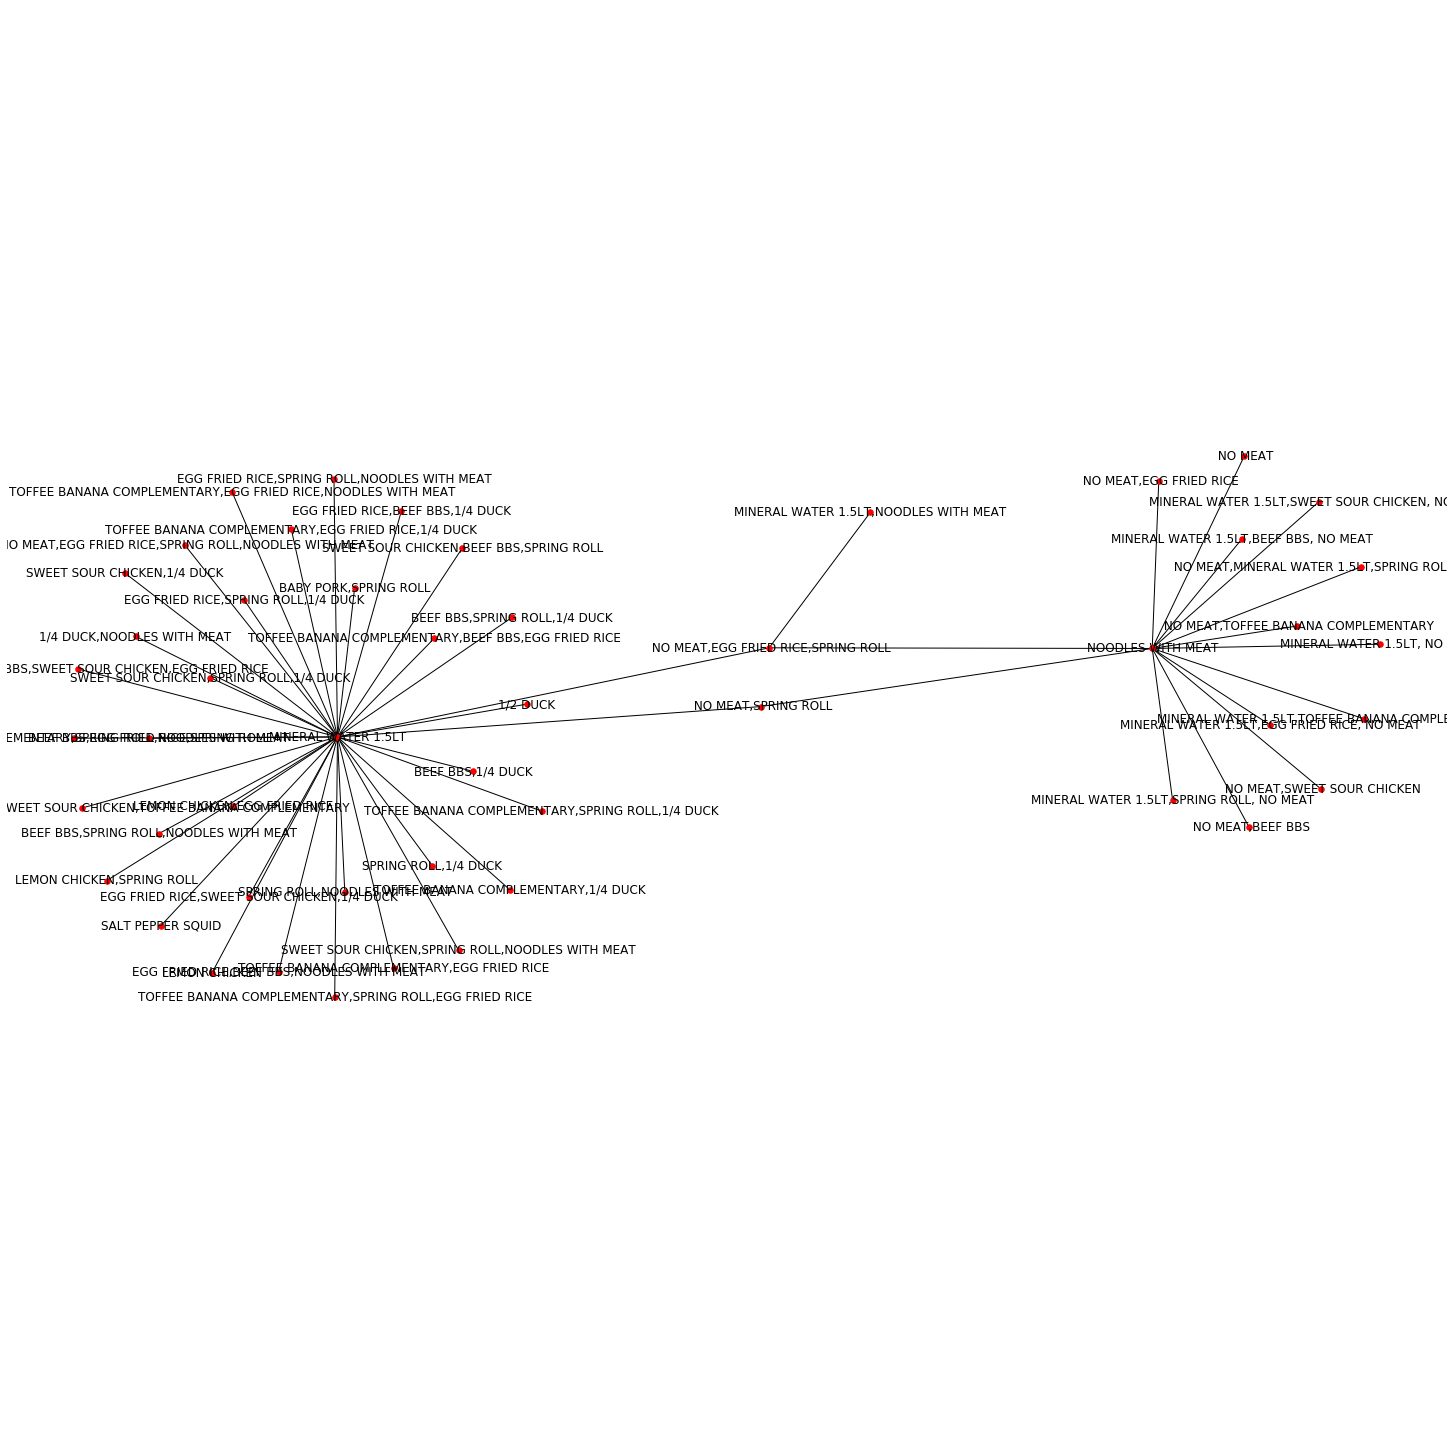

In [33]:
### Plot a basic network graph of the top 50 confidence rules 

# Create a copy of the rules and transform the frozensets to strings 
rulesToPlot_rest = rulesConfidence_rest.copy(deep=True) 
rulesToPlot_rest['LHS'] = [','.join(list(x)) for x in rulesToPlot_rest['antecedents']] 
rulesToPlot_rest['RHS'] = [','.join(list(x)) for x in rulesToPlot_rest['consequents']] 

# Remove duplicate if reversed rules 
rulesToPlot_rest['sortedRow'] = [sorted([a,b]) for a,b in zip(rulesToPlot_rest.LHS, rulesToPlot_rest.RHS)] 
rulesToPlot_rest['sortedRow'] = rulesToPlot_rest['sortedRow'].astype(str) 
rulesToPlot_rest.drop_duplicates(subset=['sortedRow'], inplace=True) 

# Plot 
rulesToPlot_rest=rulesToPlot_rest[:50] 
fig = plt.figure(figsize=(20, 20))  
G = nx.from_pandas_edgelist(rulesToPlot_rest, 'LHS', 'RHS') 
nx.draw(G, with_labels=True, node_size=30, node_color="red", pos=nx.spring_layout(G), seed=1234) 
plt.axis('equal') 
plt.show() 

## Interpretation:

In this network graph it's represented the Confidence association rule in our products, we can see 2 major groups centered in **Mineral Water** and **Noodle with meat** wich means they are the most frequent consequents, the dots closer to wich point refers to the most frequent antecendes of wich point. Closer the point more Confidence has. The ones in between means they are equally found with both consequents.

In [34]:
#Without water
frequent_itemsets_NW = apriori(pt_rest_NW, min_support=0.05, use_colnames=True) 

rulesConfidence_rest_NW = association_rules(frequent_itemsets_NW, metric="confidence", min_threshold=0.50) 
rulesConfidence_rest_NW.sort_values(by='confidence', ascending=False, inplace=True) 
print(rulesConfidence_rest_NW.head(10))

rulesSupport_rest_NW = association_rules(frequent_itemsets_NW, metric="support", min_threshold=0.20) 
rulesSupport_rest_NW.sort_values(by='support', ascending=False, inplace=True) 
print(rulesSupport_rest_NW.head(10)) 

rulesLift_rest_NW = association_rules(frequent_itemsets_NW, metric="lift", min_threshold=0) #Change to 0 so we can look into substitute products 
rulesLift_rest_NW.sort_values(by='lift', ascending=False, inplace=True) 
rulesLift_rest_NW.head(10) 

                                     antecedents          consequents  \
95       ( NO MEAT, EGG FRIED RICE, SPRING ROLL)  (NOODLES WITH MEAT)   
1                                     ( NO MEAT)  (NOODLES WITH MEAT)   
51       ( NO MEAT, TOFFEE BANANA COMPLEMENTARY)  (NOODLES WITH MEAT)   
47                ( NO MEAT, SWEET SOUR CHICKEN)  (NOODLES WITH MEAT)   
43                       ( NO MEAT, SPRING ROLL)  (NOODLES WITH MEAT)   
37                    ( NO MEAT, EGG FRIED RICE)  (NOODLES WITH MEAT)   
35                          ( NO MEAT, BEEF BBS)  (NOODLES WITH MEAT)   
5                                     (1/2 DUCK)     (EGG FRIED RICE)   
102  (SWEET SOUR CHICKEN, BEEF BBS, SPRING ROLL)     (EGG FRIED RICE)   
67                (SWEET SOUR CHICKEN, BEEF BBS)     (EGG FRIED RICE)   

     antecedent support  consequent support   support  confidence      lift  \
95             0.055573            0.183758  0.055573    1.000000  5.441941   
1              0.123885            0.1

antecedents  \
300                        ( NO MEAT, EGG FRIED RICE)   
305                  (SPRING ROLL, NOODLES WITH MEAT)   
125                                        ( NO MEAT)   
124                  (SPRING ROLL, NOODLES WITH MEAT)   
299  (EGG FRIED RICE, SPRING ROLL, NOODLES WITH MEAT)   
306                                        ( NO MEAT)   
76                                       (JIRA PULAO)   
77                                             (NAAN)   
137                                        ( NO MEAT)   
136  (TOFFEE BANANA COMPLEMENTARY, NOODLES WITH MEAT)   

                                          consequents  antecedent support  \
300                  (SPRING ROLL, NOODLES WITH MEAT)            0.077707   
305                        ( NO MEAT, EGG FRIED RICE)            0.115605   
125                  (SPRING ROLL, NOODLES WITH MEAT)            0.123885   
124                                        ( NO MEAT)            0.115605   
299                                        ( NO MEAT)            0.074682   
306  (EGG FRIED RICE, SPRING ROLL, NOODLES WITH MEAT)            0.123885   
76                                             (NAAN)            0.105414   
77                                       (JIRA PULAO)            0.117834   
137  (TOFFEE BANANA COMPLEMENTARY, NOODLES WITH MEAT)            0.123885   
136                                        ( NO MEAT)            0.077707   

     consequent support   support  confidence      lift  leverage  conviction  
300            0.115605  0.055573    0.715164  6.186267  0.046590    3.104926  
305            0.077707  0.055573    0.480716  6.186267  0.046590    1.776087  
125            0.115605  0.087102    0.703085  6.081781  0.072780    2.978611  
124            0.123885  0.087102    0.753444  6.081781  0.072780    3.553404  
299            0.123885  0.055573    0.744136  6.006654  0.046321    3.424148  
306            0.074682  0.055573    0.448586  6.006654  0.046321    1.678083  
76             0.117834  0.073567    0.697885  5.922593  0.061145    2.919968  
77             0.105414  0.073567    0.624324  5.922593  0.061145    2.381272  
137            0.077707  0.056847    0.458869  5.905116  0.047220    1.704380  
136            0.123885  0.056847    0.731557  5.905116  0.047220    3.263694

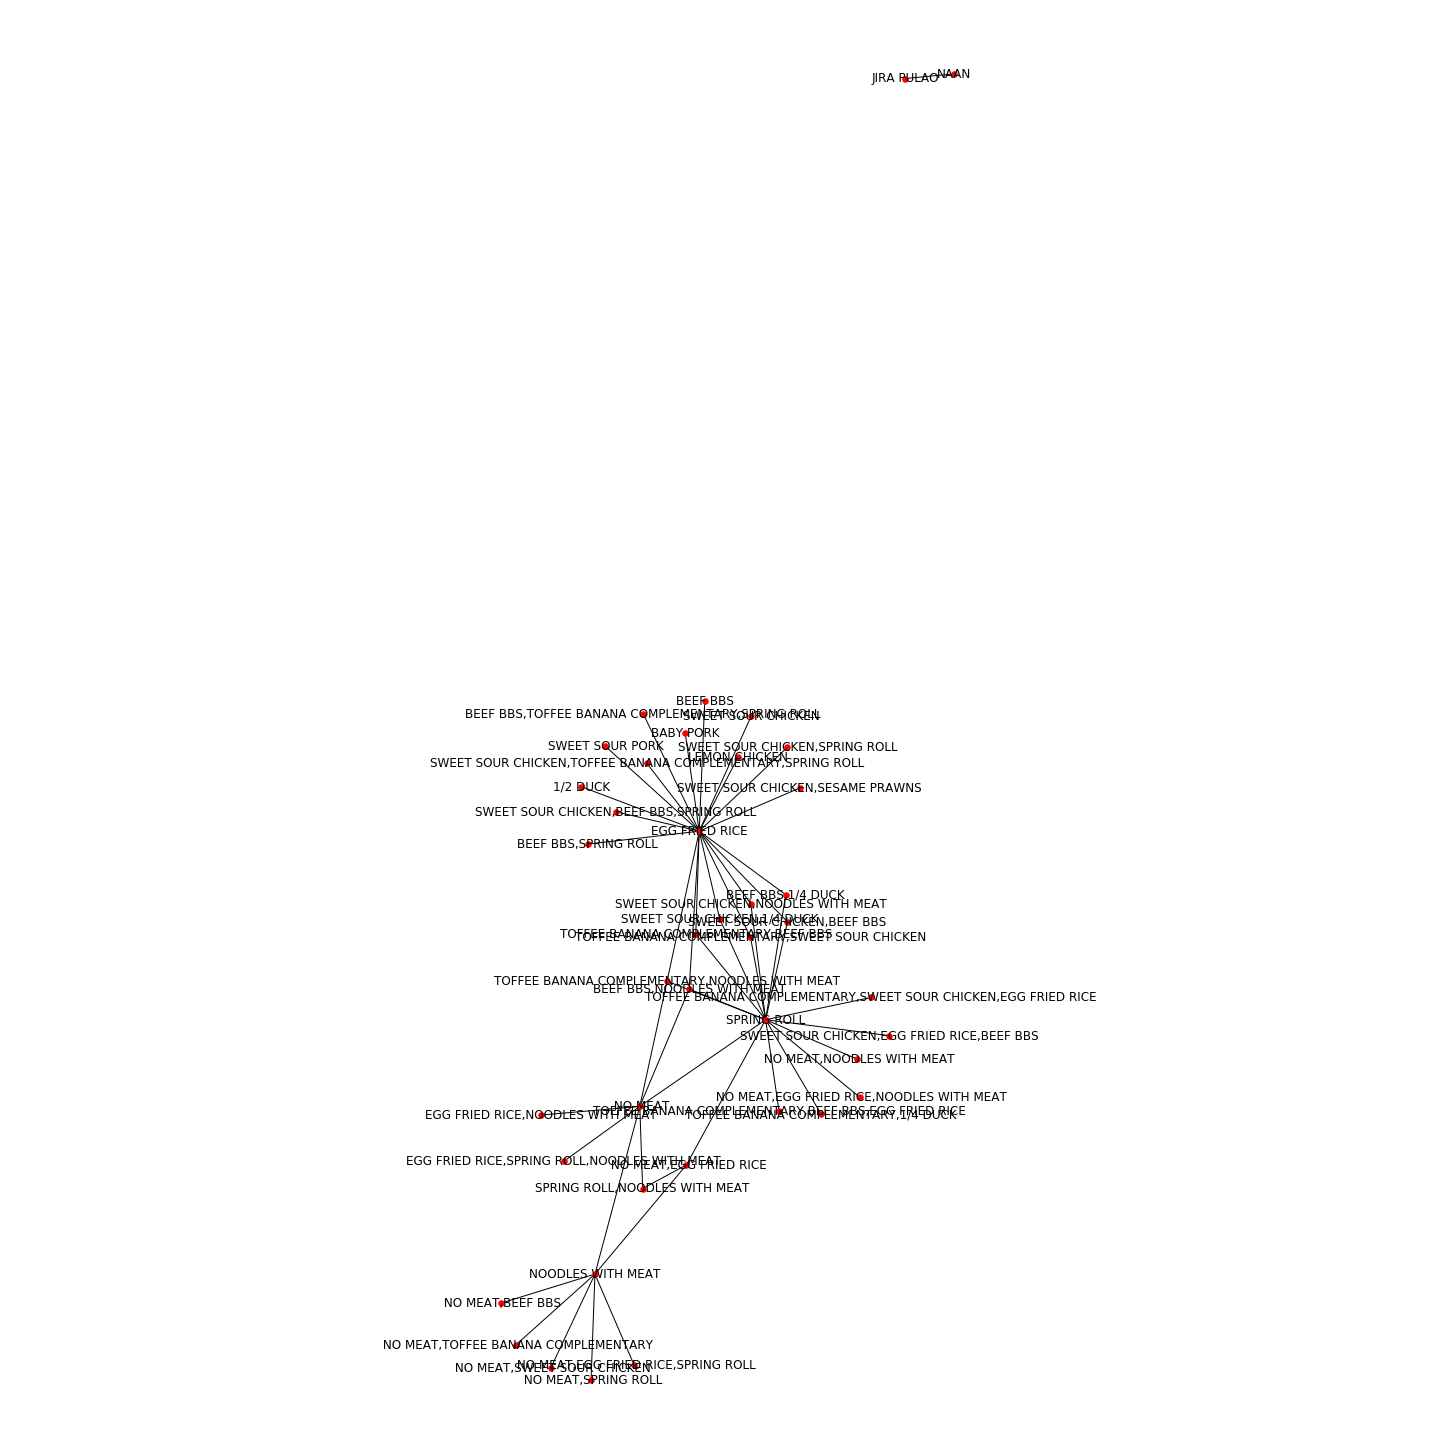

In [35]:
### Plot a basic network graph of the top 50 confidence rules 

# Create a copy of the rules and transform the frozensets to strings 
rulesToPlot_rest_NW = rulesConfidence_rest_NW.copy(deep=True) 
rulesToPlot_rest_NW['LHS'] = [','.join(list(x)) for x in rulesToPlot_rest_NW['antecedents']] 
rulesToPlot_rest_NW['RHS'] = [','.join(list(x)) for x in rulesToPlot_rest_NW['consequents']] 

# Remove duplicate if reversed rules 
rulesToPlot_rest_NW['sortedRow'] = [sorted([a,b]) for a,b in zip(rulesToPlot_rest_NW.LHS, rulesToPlot_rest_NW.RHS)] 
rulesToPlot_rest_NW['sortedRow'] = rulesToPlot_rest_NW['sortedRow'].astype(str) 
rulesToPlot_rest_NW.drop_duplicates(subset=['sortedRow'], inplace=True) 

# Plot 
rulesToPlot_rest_NW=rulesToPlot_rest_NW[:50] 
fig = plt.figure(figsize=(20, 20))  
G = nx.from_pandas_edgelist(rulesToPlot_rest_NW, 'LHS', 'RHS') 
nx.draw(G, with_labels=True, node_size=30, node_color="red", pos=nx.spring_layout(G), seed=1234) 
plt.axis('equal') 
plt.show() 

## Interpretation:

In this network graph it's represented the Confidence association rule in our products, we can see 2 major groups centered in **Egg Fried Rice** and **Spring Roll** wich means they are the most frequent consequents, the dots closer to wich point refers to the most frequent antecendes of wich point. Closer the point more Confidence has.  The ones in between means they are equally found with both consequents.
In this one we can also see 3 minor groups, 2 of them centered in **Noodles with meat** and **No meat**, and a smaller group with just 2 products far way from the others wich means they don't usually get ordered with other products.

In [36]:
#Apriori for Holidays: Restaurant and Christmas Eve

frequent_itemsets_holi_rest = apriori(pt_rest_holi, min_support=0.05, use_colnames=True) 

rulesConfidence_holi_rest = association_rules(frequent_itemsets_holi_rest, metric="confidence", min_threshold=0.50) 
rulesConfidence_holi_rest.sort_values(by='confidence', ascending=False, inplace=True) 
 
rulesLift_holi_rest = association_rules(frequent_itemsets_holi_rest, metric="lift", min_threshold=0) #Change to 0 so we can look into substitute products 
rulesLift_holi_rest.sort_values(by='lift', ascending=False, inplace=True) 
rulesLift_holi_rest.head(10)




antecedents  \
471538   (EGG FRIED RICE, TOFFEE BANANA COMPLEMENTARY, ...   
1648987  (COKE ZERO, DIET COKE, COKE, TOFFEE BANANA COM...   
1648988  (COKE ZERO, DIET COKE, COKE, TOFFEE BANANA COM...   
743010   (SWEET SOUR CHICKEN, BEEF BBS, SALT PEPPER PRA...   
1055888  (JIRA PULAO, SPRING ROLL, TOFFEE BANANA COMPLE...   
1055887       (JIRA PULAO, SPRING ROLL, NOODLES WITH MEAT)   
1569824  (MINERAL WATER 1.5LT, JIRA PULAO, COKE ZERO, E...   
1055886                (BEEF BBS, JIRA PULAO, SPRING ROLL)   
1648989  (COKE ZERO, DIET COKE, TOFFEE BANANA COMPLEMEN...   
1648990  (COKE ZERO, DIET COKE, COKE, MINERAL WATER 1.5...   

                                               consequents  \
471538   ( NO MEAT, SPRING ROLL, BEEF BBS, FRIED SHREDD...   
1648987          ( NO MEAT, JIRA PULAO, NOODLES WITH MEAT)   
1648988        ( NO MEAT, JIRA PULAO, MINERAL WATER 1.5LT)   
743010   ( NO MEAT, STEAMED RICE, TOFFEE BANANA COMPLEM...   
1055888  (COKE ZERO, COKE, BEEF BBS, NOODLES WITH MEAT,...   
1055887  (COKE ZERO, COKE, BEEF BBS, TOFFEE BANANA COMP...   
1569824  ( NO MEAT, COKE, BEEF BBS, NOODLES WITH MEAT, ...   
1055886  (COKE ZERO, COKE, NOODLES WITH MEAT, TOFFEE BA...   
1648989                       ( NO MEAT, JIRA PULAO, COKE)   
1648990             ( NO MEAT, JIRA PULAO, EGG FRIED RICE)   

         antecedent support  consequent support   support  confidence  lift  \
471538             0.090909            0.090909  0.090909         1.0  11.0   
1648987            0.090909            0.090909  0.090909         1.0  11.0   
1648988            0.090909            0.090909  0.090909         1.0  11.0   
743010             0.090909            0.090909  0.090909         1.0  11.0   
1055888            0.090909            0.090909  0.090909         1.0  11.0   
1055887            0.090909            0.090909  0.090909         1.0  11.0   
1569824            0.090909            0.090909  0.090909         1.0  11.0   
1055886            0.090909            0.090909  0.090909         1.0  11.0   
1648989            0.090909            0.090909  0.090909         1.0  11.0   
1648990            0.090909            0.090909  0.090909         1.0  11.0   

         leverage  conviction  
471538   0.082645         inf  
1648987  0.082645         inf  
1648988  0.082645         inf  
743010   0.082645         inf  
1055888  0.082645         inf  
1055887  0.082645         inf  
1569824  0.082645         inf  
1055886  0.082645         inf  
1648989  0.082645         inf  
1648990  0.082645         inf

### Interpretation Apriori for Christmas Eve in the restaurant

Due to low number of values, it is challenging to determin specific complementary products. It might occur, that people order higher priced items. For further details, please consult our report.


### New Product Ideas for Restaurants

In [37]:
#General exploration of high confidence and high lift: 
rulesConfidence_rest_NW[(rulesConfidence_rest_NW['confidence'] >= 0.5) & (rulesConfidence_rest_NW['lift'] >= 4)] 

antecedents  \
95            ( NO MEAT, EGG FRIED RICE, SPRING ROLL)   
1                                          ( NO MEAT)   
51            ( NO MEAT, TOFFEE BANANA COMPLEMENTARY)   
47                     ( NO MEAT, SWEET SOUR CHICKEN)   
43                            ( NO MEAT, SPRING ROLL)   
37                         ( NO MEAT, EGG FRIED RICE)   
35                               ( NO MEAT, BEEF BBS)   
45                   (SPRING ROLL, NOODLES WITH MEAT)   
98   (EGG FRIED RICE, SPRING ROLL, NOODLES WITH MEAT)   
52   (TOFFEE BANANA COMPLEMENTARY, NOODLES WITH MEAT)   
99                         ( NO MEAT, EGG FRIED RICE)   
46                                         ( NO MEAT)   
36                      (BEEF BBS, NOODLES WITH MEAT)   
25                                       (JIRA PULAO)   
39                (EGG FRIED RICE, NOODLES WITH MEAT)   
2                                 (NOODLES WITH MEAT)   
49            (SWEET SOUR CHICKEN, NOODLES WITH MEAT)   
100                           ( NO MEAT, SPRING ROLL)   
40                                         ( NO MEAT)   
26                                             (NAAN)   
16                               (CHICK TIKKA MASALA)   
15                               (CHICK TIKKA MASALA)   
50                                         ( NO MEAT)   
14                                       (JIRA PULAO)   

                                 consequents  antecedent support  \
95                       (NOODLES WITH MEAT)            0.055573   
1                        (NOODLES WITH MEAT)            0.123885   
51                       (NOODLES WITH MEAT)            0.056847   
47                       (NOODLES WITH MEAT)            0.064968   
43                       (NOODLES WITH MEAT)            0.087102   
37                       (NOODLES WITH MEAT)            0.077707   
35                       (NOODLES WITH MEAT)            0.052707   
45                                ( NO MEAT)            0.115605   
98                                ( NO MEAT)            0.074682   
52                                ( NO MEAT)            0.077707   
99          (SPRING ROLL, NOODLES WITH MEAT)            0.077707   
46          (SPRING ROLL, NOODLES WITH MEAT)            0.123885   
36                                ( NO MEAT)            0.075159   
25                                    (NAAN)            0.105414   
39                                ( NO MEAT)            0.112580   
2                                 ( NO MEAT)            0.183758   
49                                ( NO MEAT)            0.096497   
100      (EGG FRIED RICE, NOODLES WITH MEAT)            0.087102   
40       (EGG FRIED RICE, NOODLES WITH MEAT)            0.123885   
26                              (JIRA PULAO)            0.117834   
16                                    (NAAN)            0.090924   
15                              (JIRA PULAO)            0.090924   
50   (SWEET SOUR CHICKEN, NOODLES WITH MEAT)            0.123885   
14                      (CHICK TIKKA MASALA)            0.105414   

     consequent support   support  confidence      lift  leverage  conviction  
95             0.183758  0.055573    1.000000  5.441941  0.045361         inf  
1              0.183758  0.123885    1.000000  5.441941  0.101120         inf  
51             0.183758  0.056847    1.000000  5.441941  0.046401         inf  
47             0.183758  0.064968    1.000000  5.441941  0.053030         inf  
43             0.183758  0.087102    1.000000  5.441941  0.071096         inf  
37             0.183758  0.077707    1.000000  5.441941  0.063428         inf  
35             0.183758  0.052707    1.000000  5.441941  0.043022         inf  
45             0.123885  0.087102    0.753444  6.081781  0.072780    3.553404  
98             0.123885  0.055573    0.744136  6.006654  0.046321    3.424148  
52             0.123885  0.056847    0.731557  5.905116  0.047220    3.263694  
99             0.115605  0.055573  

In [38]:
#General exploration of high confidence and high lift: 
rulesConfidence_rest_NW[(rulesConfidence_rest_NW['confidence'] >= 0.5) & (rulesConfidence_rest_NW['support'] >= 0.2)] 

antecedents           consequents  antecedent support  \
23  (SWEET SOUR CHICKEN)      (EGG FRIED RICE)            0.308758   
21         (SPRING ROLL)      (EGG FRIED RICE)            0.357006   
20      (EGG FRIED RICE)         (SPRING ROLL)            0.390764   
22      (EGG FRIED RICE)  (SWEET SOUR CHICKEN)            0.390764   

    consequent support   support  confidence      lift  leverage  conviction  
23            0.390764  0.218631    0.708097  1.812082  0.097979    2.087117  
21            0.390764  0.222452    0.623104  1.594578  0.082947    1.616457  
20            0.357006  0.222452    0.569275  1.594578  0.082947    1.492816  
22            0.308758  0.218631    0.559495  1.812082  0.097979    1.569203

### First Interpretation:
**NO MEAT -> NOODLES WITH MEAT (Index 2)**

High Lift means complementary effects. Under the assumption that no meat is not a product but an additional item for an item with meat: People like to eat noodles with meat but also without meat. Confidence of 1 means that if customers “ordered” the item “No Meat” they also ordered “Noodles with meat”.

**SPRING ROLL  -> EGG FRIED RICE (No Water DATA)**
High Confidence (=62%) and Support (=22%) which means they are items that are often ordered together. Since "Spring Roll" it's a started and "Egg Fried Rice" a side dish ir order to be a complete meal we need at least 1 more products

**SWEET SOUR CHICKEN  -> EGG FRIED RICE (No Water DATA)**
High Confidence (=71%) and Support (=21%). Since "SWEET SOUR CHICKEN" it's a just meat and "Egg Fried Rice" a side dish, this tow combined make a main dish.

Maybe consider the hypotheses of making a menu with **SPRING ROLL, SWEET SOUR CHICKEN & EGG FRIED RICE**

**In general** within the restaurants most combinations represents menues. That is why new menues, including a drink, should be taken into account.

For further analysis and interpretation please consult our report.

### Substitute Products in Restaurants

In [39]:
rulesLift_rest[rulesLift_rest.lift<=1]

antecedents            consequents  antecedent support  \
76   (MINERAL WATER 1.5LT)                 (COKE)            0.906544   
77                  (COKE)  (MINERAL WATER 1.5LT)            0.088999   
106  (MINERAL WATER 1.5LT)           (JIRA PULAO)            0.906544   
107           (JIRA PULAO)  (MINERAL WATER 1.5LT)            0.105397   
546     (JIRA PULAO, NAAN)  (MINERAL WATER 1.5LT)            0.073555   
547  (MINERAL WATER 1.5LT)     (JIRA PULAO, NAAN)            0.906544   
119                 (NAAN)  (MINERAL WATER 1.5LT)            0.117816   
118  (MINERAL WATER 1.5LT)                 (NAAN)            0.906544   
110  (MINERAL WATER 1.5LT)                  (KEO)            0.906544   
111                  (KEO)  (MINERAL WATER 1.5LT)            0.065754   

     consequent support   support  confidence      lift  leverage  conviction  
76             0.088999  0.080401    0.088690  0.996531 -0.000280    0.999661  
77             0.906544  0.080401    0.903399  0.996531 -0.000280    0.967447  
106            0.105397  0.095208    0.105023  0.996448 -0.000339    0.999582  
107            0.906544  0.095208    0.903323  0.996448 -0.000339    0.966690  
546            0.906544  0.066391    0.902597  0.995647 -0.000290    0.959486  
547            0.073555  0.066391    0.073235  0.995647 -0.000290    0.999655  
119            0.906544  0.105556    0.895946  0.988310 -0.001249    0.898153  
118            0.117816  0.105556    0.116438  0.988310 -0.001249    0.998441  
110            0.065754  0.058908    0.064981  0.988241 -0.000701    0.999173  
111            0.906544  0.058908    0.895884  0.988241 -0.000701    0.897617

In the restaurant, with the removal of Water from the analysis, there seems to be no substitute product.
If we keep water on the analysis, we can see that it is the common product in every rule. This means that people rarely consume both Coke and Water, Beer(Keo) and Water or even Jira Pulao or Naan with Water. Nevertheless, the lift is rather close to 1, which means that these products are weak substitutes.

### Modelling for Deliveries

In [40]:
frequent_itemsets_deli = apriori(pt_deli, min_support=0.05, use_colnames=True) 

rulesConfidence_deli = association_rules(frequent_itemsets_deli, metric="confidence", min_threshold=0.50) 
rulesConfidence_deli.sort_values(by='confidence', ascending=False, inplace=True) 
print(rulesConfidence_deli.head(10)) 

rulesSupport_deli = association_rules(frequent_itemsets_deli, metric="support", min_threshold=0.20) 
rulesSupport_deli.sort_values(by='support', ascending=False, inplace=True) 
print(rulesSupport_deli.head(10)) 

 
rulesLift_deli = association_rules(frequent_itemsets_deli, metric="lift", min_threshold=0) 
rulesLift_deli.sort_values(by='lift', ascending=False, inplace=True) 
rulesLift_deli.head(10) 

                          antecedents          consequents  \
2                          ( NO MEAT)  (NOODLES WITH MEAT)   
0                   ( EXTRA PANCAKES)       ( EXTRA SAUCE)   
1                      ( EXTRA SAUCE)    ( EXTRA PANCAKES)   
14     (SWEET SOUR CHICKEN, 1/4 DUCK)     (EGG FRIED RICE)   
9                (SWEET SOUR CHICKEN)     (EGG FRIED RICE)   
19       (SWEET SOUR CHICKEN, TSANTA)     (EGG FRIED RICE)   
15  (SPRING ROLL, SWEET SOUR CHICKEN)     (EGG FRIED RICE)   
5                     (LEMON CHICKEN)     (EGG FRIED RICE)   
4                          (BEEF BBS)     (EGG FRIED RICE)   
12            (SPRING ROLL, 1/4 DUCK)     (EGG FRIED RICE)   

    antecedent support  consequent support   support  confidence      lift  \
2             0.062474            0.125976  0.062474    1.000000  7.938010   
0             0.085491            0.090423  0.063913    0.747596  8.267734   
1             0.090423            0.085491  0.063913    0.706818  8.267734   
14   

antecedents                     consequents  \
1                   ( EXTRA SAUCE)               ( EXTRA PANCAKES)   
0                ( EXTRA PANCAKES)                  ( EXTRA SAUCE)   
2                       ( NO MEAT)             (NOODLES WITH MEAT)   
3              (NOODLES WITH MEAT)                      ( NO MEAT)   
44                    (JIRA PULAO)                          (NAAN)   
45                          (NAAN)                    (JIRA PULAO)   
77      (EGG FRIED RICE, 1/4 DUCK)            (SWEET SOUR CHICKEN)   
80            (SWEET SOUR CHICKEN)      (EGG FRIED RICE, 1/4 DUCK)   
79                (EGG FRIED RICE)  (SWEET SOUR CHICKEN, 1/4 DUCK)   
78  (SWEET SOUR CHICKEN, 1/4 DUCK)                (EGG FRIED RICE)   

    antecedent support  consequent support   support  confidence      lift  \
1             0.090423            0.085491  0.063913    0.706818  8.267734   
0             0.085491            0.090423  0.063913    0.747596  8.267734   
2             0.062474            0.125976  0.062474    1.000000  7.938010   
3             0.125976            0.062474  0.062474    0.495922  7.938010   
44            0.097205            0.119400  0.052815    0.543340  4.550593   
45            0.119400            0.097205  0.052815    0.442341  4.550593   
77            0.126798            0.335799  0.070695    0.557536  1.660326   
80            0.335799            0.126798  0.070695    0.210526  1.660326   
79            0.412659            0.105220  0.070695    0.171315  1.628159   
78            0.105220            0.412659  0.070695    0.671875  1.628159   

    leverage  conviction  
1   0.056182    3.119255  
0   0.056182    3.603656  
2   0.054604         inf  
3   0.054604    1.859881  
44  0.041209    1.928351  
45  0.041209    1.618901  
77  0.028116    1.501142  
80  0.028116    1.106056  
79  0.027275    1.079759  
78  0.027275    1.789991

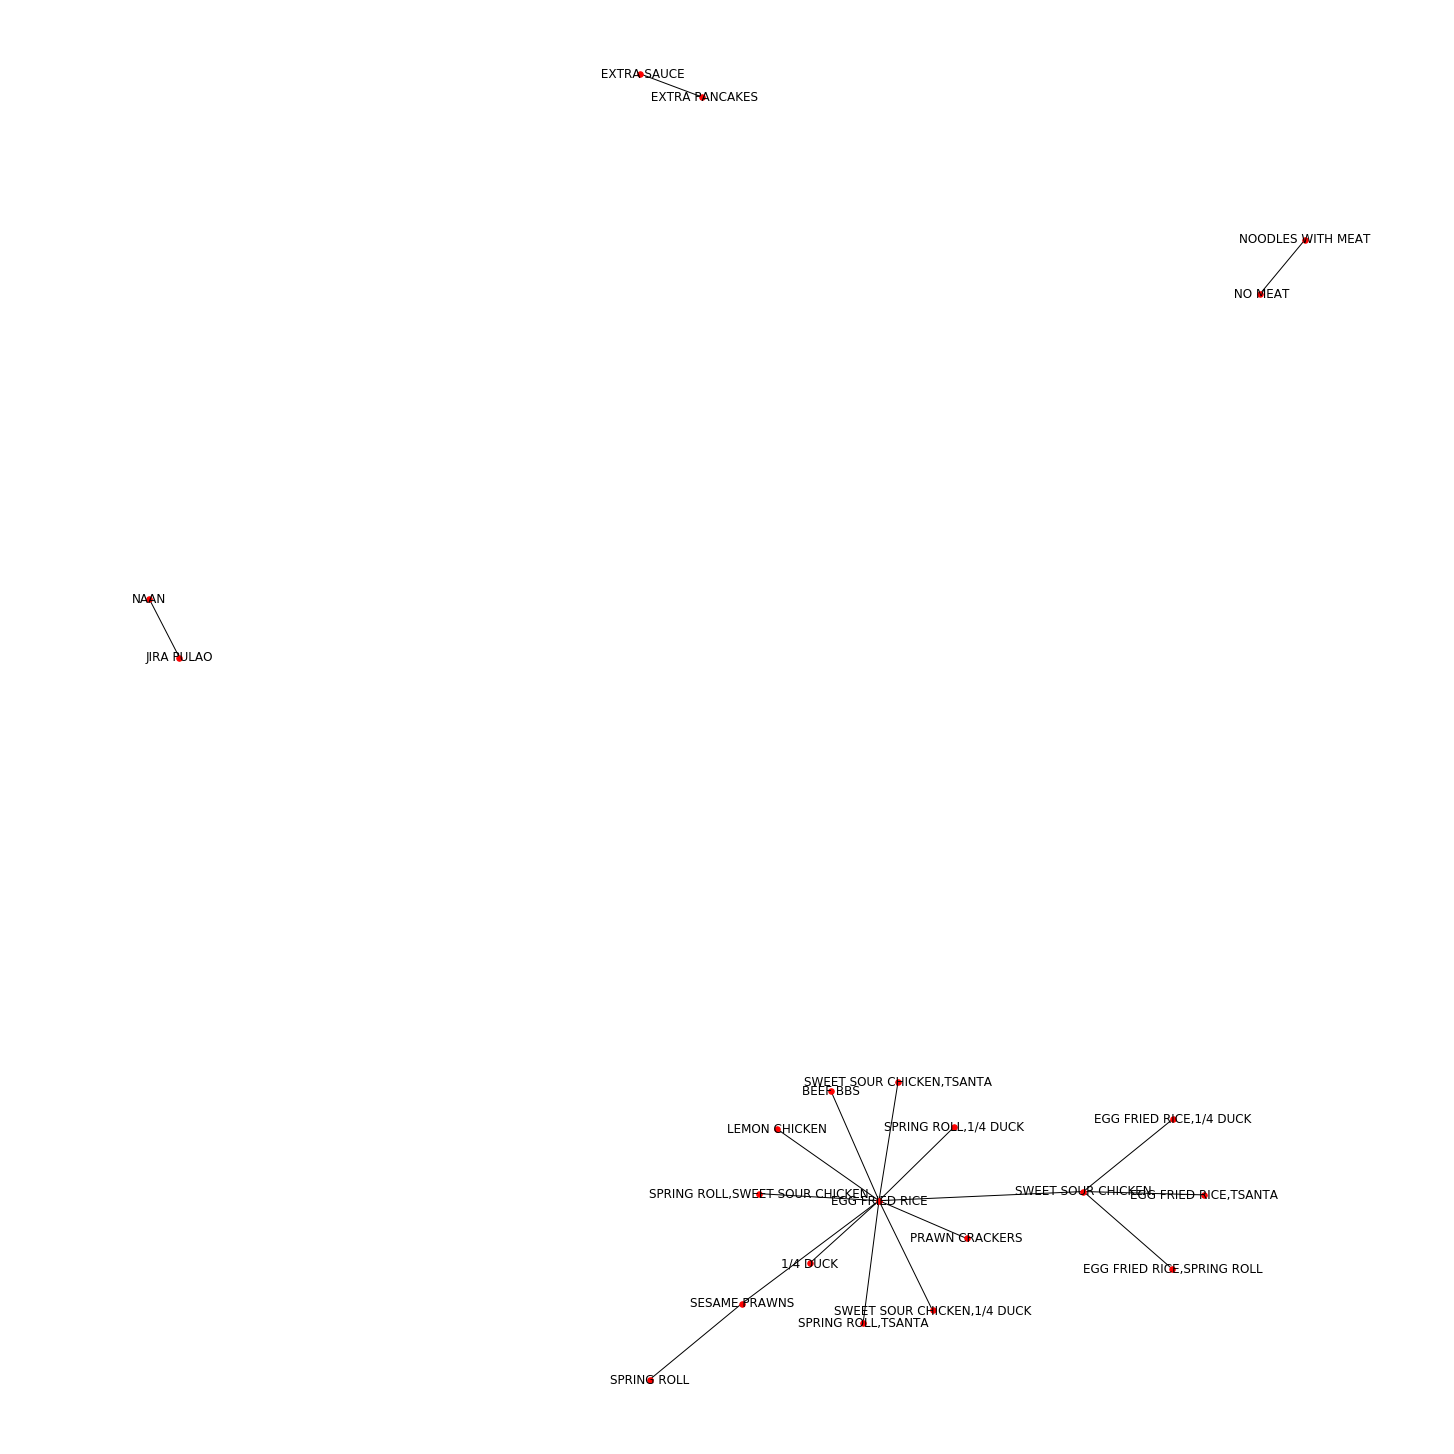

In [41]:
### Plot a basic network graph of the top 50 confidence rules 

# Create a copy of the rules and transform the frozensets to strings 
rulesToPlot_deli = rulesConfidence_deli.copy(deep=True) 
rulesToPlot_deli['LHS'] = [','.join(list(x)) for x in rulesToPlot_deli['antecedents']] 
rulesToPlot_deli['RHS'] = [','.join(list(x)) for x in rulesToPlot_deli['consequents']] 

# Remove duplicate if reversed rules 
rulesToPlot_deli['sortedRow'] = [sorted([a,b]) for a,b in zip(rulesToPlot_deli.LHS, rulesToPlot_deli.RHS)] 
rulesToPlot_deli['sortedRow'] = rulesToPlot_deli['sortedRow'].astype(str) 
rulesToPlot_deli.drop_duplicates(subset=['sortedRow'], inplace=True) 

# Plot 
rulesToPlot_deli=rulesToPlot_deli[:50] 
fig = plt.figure(figsize=(20, 20))  
G = nx.from_pandas_edgelist(rulesToPlot_deli, 'LHS', 'RHS') 
nx.draw(G, with_labels=True, node_size=30, node_color="red", pos=nx.spring_layout(G), seed=1234) 
plt.axis('equal') 
plt.show() 

## Interpretation:

In this network graph it's represented the Confidence association rule in our products, we can see 2 groups centered in **Egg Fried Rice** and **Sweet Sour Chicken** wich means they are the most frequent consequents, the dots closer to wich point refers to the most frequent antecendes of wich point. Closer the point more Confidence has. We can also see that the center are connected, this means they are also usually order together.
It's also visible 3 small groups composed just with 2 products each one, this means they are most of the time not ordered with other products.

In [42]:
#Apriori for Holidays: Delivery and New Year's Eve

frequent_itemsets_holi_deli = apriori(pt_deli_holi, min_support=0.05, use_colnames=True) 

rulesConfidence_holi_deli = association_rules(frequent_itemsets_holi_deli, metric="confidence", min_threshold=0.50) 
rulesConfidence_holi_deli.sort_values(by='confidence', ascending=False, inplace=True) 
 
rulesLift_holi_deli = association_rules(frequent_itemsets_holi_deli, metric="lift", min_threshold=0) #Change to 0 so we can look into substitute products 
rulesLift_holi_deli.sort_values(by='lift', ascending=False, inplace=True) 
rulesLift_holi_deli.head(5)

antecedents  \
548                  (1/2 DUCK, DELIVERY CHARGE)   
760               (1/2 DUCK, SWEET SOUR CHICKEN)   
752  (SPRING ROLL, BEEF BBS, SWEET SOUR CHICKEN)   
559                      (BEEF BBS, SPRING ROLL)   
534                  (1/2 DUCK, DELIVERY CHARGE)   

                                  consequents  antecedent support  \
548            (BEEF BBS, SWEET SOUR CHICKEN)            0.090909   
760  (SPRING ROLL, BEEF BBS, DELIVERY CHARGE)            0.090909   
752               (1/2 DUCK, DELIVERY CHARGE)            0.090909   
559            (1/2 DUCK, SWEET SOUR CHICKEN)            0.090909   
534                   (BEEF BBS, SPRING ROLL)            0.090909   

     consequent support   support  confidence  lift  leverage  conviction  
548            0.090909  0.090909         1.0  11.0  0.082645         inf  
760            0.090909  0.090909         1.0  11.0  0.082645         inf  
752            0.090909  0.090909         1.0  11.0  0.082645         inf  
559            0.090909  0.090909         1.0  11.0  0.082645         inf  
534            0.090909  0.090909         1.0  11.0  0.082645         inf

### Interpretation Apriori for New Year's Eve Delivery

Due to low number of values, it is challenging to determin specific complementary products. It might occur, that people order mainly duck in combination with other meat dishes. A combined dish on New Year's eve for deliveries would be a possibility. For further details, please consult our report.

### New Product Ideas for Deliveries

In [43]:
#General exploration of high confidence and high lift: 
rulesConfidence_deli[(rulesConfidence_deli['confidence'] >= 0.5) & (rulesConfidence_deli['lift'] >= 4)]

antecedents          consequents  antecedent support  \
2          ( NO MEAT)  (NOODLES WITH MEAT)            0.062474   
0   ( EXTRA PANCAKES)       ( EXTRA SAUCE)            0.085491   
1      ( EXTRA SAUCE)    ( EXTRA PANCAKES)            0.090423   
10       (JIRA PULAO)               (NAAN)            0.097205   

    consequent support   support  confidence      lift  leverage  conviction  
2             0.125976  0.062474    1.000000  7.938010  0.054604         inf  
0             0.090423  0.063913    0.747596  8.267734  0.056182    3.603656  
1             0.085491  0.063913    0.706818  8.267734  0.056182    3.119255  
10            0.119400  0.052815    0.543340  4.550593  0.041209    1.928351

In [44]:
rulesConfidence_deli[(rulesConfidence_deli['confidence'] >= 0.5) & (rulesConfidence_deli['support'] >= 0.2)]

antecedents           consequents  antecedent support  \
9  (SWEET SOUR CHICKEN)      (EGG FRIED RICE)            0.335799   
8      (EGG FRIED RICE)  (SWEET SOUR CHICKEN)            0.412659   

   consequent support   support  confidence      lift  leverage  conviction  
9            0.412659  0.215577    0.641983  1.555721  0.077007    1.640538  
8            0.335799  0.215577    0.522410  1.555721  0.077007    1.390735

## First Interpretation:
**NO MEAT -> NOODLES WITH MEAT (Index 2)**

High Lift (=7.9) means complementary effects. Under the assumption that no meat is not a product but an additional item for an item with meat: People like to eat noodles with meat (support of 12.6 %) but also without meat (support of 6.2 %). Confidence of 1 means that if customers “ordered” the item “No Meat” they also ordered “Noodles with meat”. 

**JIRA PULAU -> NAAN (Index 10)**

A rather high lift (=4.6): complementary effects. Furthermore, both a side dishes or starters.


**SWEET SOUR CHICKEN  -> EGG FRIED RICE (No Water DATA)**

Confidence (=62%) and Support (=22%) high, we can consider a special menu for this order.

For further analysis and interpretation please consult our report.

### Substitute Products in Deliveries

In [45]:
rulesLift_deli[rulesLift_deli.lift<=1] #No substitute products in Deliveries

Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, leverage, conviction]
Index: []

In deliveries, there seems to be no substitute products

## Recommendation system
In this part we created a prototype for a recommendation system. The main purpose of this tool is a real-time recommendation of an additional meal or other extra for the current customer. As this is only a prototype, it is a quite simple approach which should solely demonstrate the general functionality. In our report you will find a detailed description of the idea behind this recommendation system, how it can be used in practice and how the model could be extended.
Before we can make useful recommendation, we need to filter our existing database in a way that it only consists of orders that have similar characteristics as the current one. As we have different data points in the restaurant and the deliveries, the filter for the two channels are based on different features.

### For restaurants 
In the restaurant context, we first filter the dataset by the features isDinner, Pax (binned) and isHoliday, and then we recommend the products with highest lift based the ordered items of the current customer.
    

In [46]:
# Change dtype to datetime
df.InvoiceDateHour = pd.to_datetime(df.InvoiceDateHour, format='%Y-%m-%d %H:%M:%S.%f')
# Mark order as dinner if invoice hour bigger 17
df["isDinner"] = [0 if x.hour < 17 else 1 for x in df.InvoiceDateHour]

# Bin pax
df["PaxBinned"] = ["1-2" if x <= 2 else "3-5" if x <=5 else "6+" for x in df.Pax ]

# isHoliday
df["isHoliday"] = [0 if x == "No Holiday" else 1 for x in df.Name]

In [47]:
# Check sizes of customer segments
# For the purpose of the prototype we define 75 observations per field as the minimum
df_res = df[df.IsDelivery == 0]
pd.crosstab(df_res.PaxBinned,[df_res.isDinner, df_res.isHoliday])

isDinner      0           1     
isHoliday     0    1      0    1
PaxBinned                       
1-2         991   71  13480  545
3-5        2764  305  20259  661
6+         2204  333  10629  619

In [48]:
# Helping functions 

# This function returns the transactions dataseet filtered by restaurant customers, pax, isHoliday and isDinner
def filter_df_pax(pax):
    # Get current time and check if dinner
    is_dinner = 1
    if dt.datetime.now().hour < 17:
        is_dinner = 0
        
    # Get current date and check if holiday
    is_holiday = 0
    if len(holidays[(holidays.Month == dt.datetime.now().month) & (holidays.Day == dt.datetime.now().day)]) != 0:
        is_holiday = 1
    
    # Get bin for pax
    if pax <= 2: 
        bin_pax = "1-2"
    elif pax <= 5:
        bin_pax = "3-5"
    else:
        bin_pax = "6+"
    
    # Filter dataset 
    df_rec = df[(df.IsDelivery == 0) & (df.isDinner == is_dinner) & (df.isHoliday == is_holiday) & (df.PaxBinned == bin_pax)].copy(deep=True)
    
    return df_rec

# This function returns a list of alphabetically sorted strings with all possible itemset combinations
def get_itemsstrings(items):
     # Get all possible combinations as a list of tuples
    itemsets = []
    for i in range(1,len(items) + 1):
        for i in itertools.combinations(items, i):
            itemsets.append(i)

    # Transform tuples into list of strings, sort the list alphabetically and create string out of sorted list 
    itemslists = [list(x) for x in itemsets]
    for i in itemslists:
        i.sort()
    itemsstrings = [" ".join(x) for x in itemslists]
    return itemsstrings

# This functions returns a dataframe with rules, based on the df returned by filter_df(pax)
def get_rules(pax, support_min, confidence_min):
    
    # Create frequent itemset of filtered df
    pt_rec = pd.pivot_table(filter_df_pax(pax)[["DocNumber","ProductDesignation"]], index='DocNumber', columns='ProductDesignation', aggfunc=lambda x: 1 if len(x)>0 else 0).fillna(0) 
    frequent_itemsets = apriori(pt_rec, min_support=support_min, use_colnames=True) 
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=confidence_min)
    
    # Remove duplicate if reversed rules
    rules['LHS'] = [','.join(list(x)) for x in rules['antecedents']]
    rules['RHS'] = [','.join(list(x)) for x in rules['consequents']]
    rules['sortedRow'] = [sorted([a,b]) for a,b in zip(rules.LHS, rules.RHS)]
    rules['sortedRow'] = rules['sortedRow'].astype(str)
    rules.drop_duplicates(subset=['sortedRow'], inplace=True)

    # Transform antecedents and consequents into list of strings, sort the list alphabetically and create string out of sorted list 
    rules["antecedents"] = rules["antecedents"].apply(lambda x: list(x))
    rules["consequents"] = rules["consequents"].apply(lambda x: list(x))

    for i in rules.index.values:
        rules.loc[i,"antecedents"].sort()
        rules.loc[i,"consequents"].sort()

    rules["antecedents"] = rules["antecedents"].apply(lambda x: " ".join(x))
    rules["consequents"] = rules["consequents"].apply(lambda x: " ".join(x))

    # Remove space in the beginning of antecedents and consequents
    rules["antecedents"] = rules["antecedents"].apply(lambda x: x[1:] if x[0] == " " else x)
    rules["consequents"] = rules["consequents"].apply(lambda x: x[1:] if x[0] == " " else x)
    
    return rules

In [49]:
# Get recommended products 
# Based on number of persons and ordered items, return maximum 10 itemsets with the highest lift

def get_recommendation_rest(pax, items, support_min=0.03, confidence_min=0.1, lift_min=1.1):
    itemsstrings = get_itemsstrings(items)
    rules = get_rules(pax, support_min, confidence_min)
    
    # Filter possible recommendations
    recoms = rules[rules.antecedents.isin(itemsstrings)]
    # Sort by lift and select relevant information of top ten
    top_ten = recoms.sort_values("lift", ascending=False)[:10][["antecedents", "consequents", "support", "confidence", "lift"]]
    
    # Only consider rules with certain lift 
    top_ten = top_ten[top_ten.lift >= lift_min]
    
    return top_ten

In [50]:
# Example: A couple ordering "SPRING ROLL", "SWEET SOUR CHICKEN", "COKE ZERO", "EGG FRIED RICE"
get_recommendation_rest(2, ["NAAN", "SWEET SOUR CHICKEN", "COKE ZERO", "EGG FRIED RICE"])

antecedents           consequents   support  \
67                                NAAN    CHICK TIKKA MASALA  0.062893   
746  EGG FRIED RICE SWEET SOUR CHICKEN     1/6 DUCK BEEF BBS  0.031447   
85                      EGG FRIED RICE          FORTUNE PORK  0.044025   
832  EGG FRIED RICE SWEET SOUR CHICKEN  1/6 DUCK SPRING ROLL  0.056604   
50                      EGG FRIED RICE              BEEF BBS  0.125786   
81                           COKE ZERO           SPRING ROLL  0.062893   
383  EGG FRIED RICE SWEET SOUR CHICKEN              BEEF BBS  0.069182   
93                      EGG FRIED RICE    SALT PEPPER PRAWNS  0.050314   
100                     EGG FRIED RICE    SWEET SOUR CHICKEN  0.220126   
946  EGG FRIED RICE SWEET SOUR CHICKEN  BEEF BBS SPRING ROLL  0.037736   

     confidence      lift  
67     0.476190  6.309524  
746    0.142857  2.523810  
85     0.112903  2.243952  
832    0.257143  2.044286  
50     0.322581  1.768632  
81     0.625000  1.743421  
383    0.314286  1.723153  
93     0.129032  1.709677  
100    0.564516  1.662186  
946    0.171429  1.603361

### For deliveries 
In the delivery context, we first filter the dataset by the features isDinner, isHoliday and Location, and then we recommend the products with highest lift based the ordered items of the current customer."
  

In [51]:
# Change dtype to datetime
df.InvoiceDateHour = pd.to_datetime(df.InvoiceDateHour, format='%Y-%m-%d %H:%M:%S.%f')
# Mark order as dinner if invoice hour bigger 17
df["isDinner"] = [0 if x.hour < 17 else 1 for x in df.InvoiceDateHour]

# isHoliday
df["isHoliday"] = [0 if x == "No Holiday" else 1 for x in df.Name]

In [52]:
# Check sizes of customer segments
df_del = df[df.IsDelivery == 1]
pd.crosstab(df_del.CustomerCity,[df_del.isDinner, df_del.isHoliday])
# for the prototype we only use the location feature, if there are more than 75 datapoints in the field

isDinner            0         1     
isHoliday           0   1     0    1
CustomerCity                        
AGIOS DOMETIOS     27   0  1242   24
AGLANTZIA          12   0   983   47
DALI               47  13   613   36
EGKOMI            732  55  7886  756
GERI                0   0     7   11
LAKATAME            0   0    52    0
LAKATAMEIA         75  11  4426  190
LATSIA              5   0   595   23
LEYKOSIA          197   8  3713  233
NICOSIA           108  36  1870   67
PANO DEYTERA        0   0    14    0
STROBOLOS         195  13  6384  461
SYN. ANTHOYPOLIS    0   0    14    5
TSERI               0   0    62    0

In [53]:
# Helping functions 

# This function returns the transactions dataseet filtered by delivery customers, city, isHoliday and isDinner
def filter_df_city(city):
    # Get current time and check if dinner
    is_dinner = 1
    if dt.datetime.now().hour < 17:
        is_dinner = 0
        
    # Get current date and check if holiday
    is_holiday = 0
    if len(holidays[(holidays.Month == dt.datetime.now().month) & (holidays.Day == dt.datetime.now().day)]) != 0:
        is_holiday = 1

    
    # Filter dataset 
    df_rec = df[(df.IsDelivery == 1) & (df.isDinner == is_dinner) & (df.isHoliday == is_holiday) & (df.CustomerCity == city)].copy(deep=True)
    if len(df_rec.index.values) > 75:
        return df_rec
    else: 
        return df[(df.IsDelivery == 1) & (df.isDinner == is_dinner) & (df.isHoliday == is_holiday)].copy(deep=True)

# This function returns a list of alphabetically sorted strings with all possible itemset combinations
def get_itemsstrings(items):
     # Get all possible combinations as a list of tuples
    itemsets = []
    for i in range(1,len(items) + 1):
        for i in itertools.combinations(items, i):
            itemsets.append(i)

    # Transform tuples into list of strings, sort the list alphabetically and create string out of sorted list 
    itemslists = [list(x) for x in itemsets]
    for i in itemslists:
        i.sort()
    itemsstrings = [" ".join(x) for x in itemslists]
    return itemsstrings

# This functions returns a dataframe with rules, based on the df returned by filter_df(city)
def get_rules_deli(city, support_min, confidence_min):
    
    # Create frequent itemset of filtered df
    pt_rec = pd.pivot_table(filter_df_city(city)[["DocNumber","ProductDesignation"]], index='DocNumber', columns='ProductDesignation', aggfunc=lambda x: 1 if len(x)>0 else 0).fillna(0) 
    frequent_itemsets = apriori(pt_rec, min_support=support_min, use_colnames=True) 
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=confidence_min)
    
    # Remove duplicate if reversed rules
    rules['LHS'] = [','.join(list(x)) for x in rules['antecedents']]
    rules['RHS'] = [','.join(list(x)) for x in rules['consequents']]
    rules['sortedRow'] = [sorted([a,b]) for a,b in zip(rules.LHS, rules.RHS)]
    rules['sortedRow'] = rules['sortedRow'].astype(str)
    rules.drop_duplicates(subset=['sortedRow'], inplace=True)

    # Transform antecedents and consequents into list of strings, sort the list alphabetically and create string out of sorted list 
    rules["antecedents"] = rules["antecedents"].apply(lambda x: list(x))
    rules["consequents"] = rules["consequents"].apply(lambda x: list(x))

    for i in rules.index.values:
        rules.loc[i,"antecedents"].sort()
        rules.loc[i,"consequents"].sort()

    rules["antecedents"] = rules["antecedents"].apply(lambda x: " ".join(x))
    rules["consequents"] = rules["consequents"].apply(lambda x: " ".join(x))

    # Remove space in the beginning of antecedents and consequents
    rules["antecedents"] = rules["antecedents"].apply(lambda x: x[1:] if x[0] == " " else x)
    rules["consequents"] = rules["consequents"].apply(lambda x: x[1:] if x[0] == " " else x)
    
    return rules

In [54]:
# Get recommended products 
# Based on location and ordered items, return maximum 10 itemsets with the highest lift

def get_recommendation_deli(city, items, support_min=0.03, confidence_min=0.1, lift_min=1.1):
    itemsstrings = get_itemsstrings(items)
    rules = get_rules_deli(city, support_min, confidence_min)
    
    # Filter possible recommendations
    recoms = rules[rules.antecedents.isin(itemsstrings)]
    # Sort by lift and select relevant information of top ten
    top_ten = recoms.sort_values("lift", ascending=False)[:10][["antecedents", "consequents", "support", "confidence", "lift"]]
    
    # Only consider rules with certain lift 
    top_ten = top_ten[top_ten.lift >= lift_min]
    
    return top_ten

In [55]:
# Example: Customer from Egkomi ordering "SPRING ROLL", "SWEET SOUR CHICKEN", "COKE ZERO", "EGG FRIED RICE"
get_recommendation_deli("EGKOMI", ["SPRING ROLL", "SWEET SOUR CHICKEN", "COKE ZERO", "EGG FRIED RICE"])

antecedents                  consequents   support  \
811  SPRING ROLL SWEET SOUR CHICKEN         EXTRA SAUCE 1/4 DUCK  0.037037   
726  SPRING ROLL SWEET SOUR CHICKEN  EXTRA PANCAKES  EXTRA SAUCE  0.044444   
796  SPRING ROLL SWEET SOUR CHICKEN     EXTRA SALAD  EXTRA SAUCE  0.037037   
754  SPRING ROLL SWEET SOUR CHICKEN      EXTRA PANCAKES 1/4 DUCK  0.044444   
366  SPRING ROLL SWEET SOUR CHICKEN                  EXTRA SAUCE  0.044444   
684  SPRING ROLL SWEET SOUR CHICKEN  EXTRA PANCAKES  EXTRA SALAD  0.037037   
348  SPRING ROLL SWEET SOUR CHICKEN                  EXTRA SALAD  0.037037   
546      EGG FRIED RICE SPRING ROLL           SWEET SOUR CHICKEN  0.059259   
174              SWEET SOUR CHICKEN            SALT PEPPER SQUID  0.037037   
312  SPRING ROLL SWEET SOUR CHICKEN               EXTRA PANCAKES  0.051852   

     confidence      lift  
811    0.416667  6.250000  
726    0.500000  5.192308  
796    0.416667  5.113636  
754    0.500000  4.821429  
366    0.500000  4.821429  
684    0.416667  4.326923  
348    0.416667  4.326923  
546    0.727273  3.636364  
174    0.185185  3.571429  
312    0.583333  3.423913